In [82]:
import wfdb
from wfdb import processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
PATH = "apnea-ecg-database-1.0.0/"

SAMPFROM = 10000
SAMPTO = 15000

In [83]:
record_ecg = wfdb.rdrecord(PATH + "a01", sampfrom=SAMPFROM, sampto=SAMPTO)
annotation = wfdb.rdann(PATH+ "a01", 'qrs', sampfrom=SAMPFROM, sampto=SAMPTO, shift_samps=True)

df2 = record_ecg.to_dataframe()
df2['time'] = df2.index.microseconds / 1000 + df2.index.seconds * 1000
df2 = df2[['time', 'ECG']]
df2.reset_index(drop=True, inplace=True)
df2.head()

,time,ECG
0,0.0,-0.030
1,10.0,0.020
2,20.0,0.020
3,30.0,0.060
4,40.0,0.115


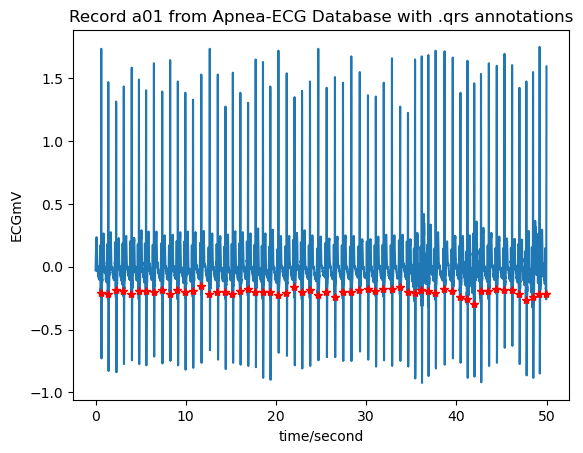

In [84]:
wfdb.plot_wfdb(record=record_ecg, annotation=annotation,
               title='Record a01 from Apnea-ECG Database with .qrs annotations',
               time_units='seconds')

[  59  137  224  308  397  477  556  643  735  823  908  991 1076 1168
 1262 1351 1436 1518 1601 1686 1771 1851 1933 2023 2115 2202 2285 2373
 2465 2558 2650 2739 2831 2925 3016 3103 3191 3281 3372 3459 3537 3612
 3685 3766 3864 3956 4041 4119 4194 4269 4356 4443 4530 4614 4695 4772
 4846 4919 4995]
[78. 87. 84. 89. 80. 79. 87. 92. 88. 85. 83. 85. 92. 94. 89. 85. 82. 83.
 85. 85. 80. 82. 90. 92. 87. 83. 88. 92. 93. 92. 89. 92. 94. 91. 87. 88.
 90. 91. 87. 78. 75. 73. 81. 98. 92. 85. 78. 75. 75. 87. 87. 87. 84. 81.
 77. 74. 73. 76.]


Text(0.5, 1.0, 'Fragment zapisu EKG dla jednego uderzenia')

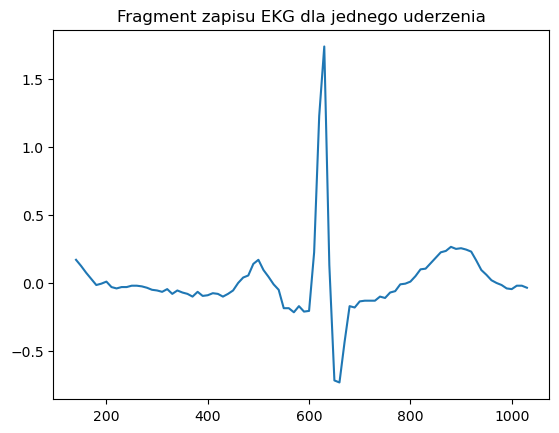

In [85]:
#przetwarzanie danych timeeeeeeee
print(annotation.sample)
num_of_beats = annotation.sample.size - 1
offset_l = 20
offset_r = 70

temp = np.zeros(num_of_beats)

for beat in range(num_of_beats):
    temp[beat] = annotation.sample[beat+1] - annotation.sample[beat]
print(temp)

#test czy to pojedyncze bicie

plt.plot(df2['time'][34 - offset_l:34+offset_r], df2['ECG'][34 - offset_l:34 + offset_r])
plt.title('Fragment zapisu EKG dla jednego uderzenia')

In [86]:
beats = np.zeros((num_of_beats, offset_l+offset_r))

for beat in range(num_of_beats):
    start_pos = annotation.sample[beat]
    beats[beat] = df2['ECG'][start_pos-offset_l:start_pos+offset_r]



In [87]:
#jakas zabawa
# qrs_inds = processing.qrs.gqrs_detect(sig=record_ecg.p_signal[:,0], fs=200)
# qrs_inds = (1 / record_ecg.fs) * qrs_inds
# # print(qrs_inds.size)
# # Utwórz nowy wykres i oś
# signal = record_ecg.p_signal[:, 0]
# time = (1 / record_ecg.fs) * np.arange(len(signal))

# # Utwórz nowy wykres
# fig, ax = plt.subplots()

# # Wyświetl sygnał EKG na wykresie
# ax.plot(time, signal)

# # Wygeneruj i wyrysuj dodatkowe punkty na tym samym wykresie
# ax.plot(qrs_inds, np.zeros(qrs_inds.size), 'ro')  # 'ro' oznacza czerwone kropki

# # Wyświetl wykres z dodatkowymi punktami i etykietami
# plt.show()

In [88]:
scaler = StandardScaler()
scaler.fit(beats)
X_scaled = scaler.transform(beats)

In [89]:
pca = decomposition.PCA(n_components=4)
X_transformed = pca.fit_transform(X_scaled)

In [90]:
eigen_vectors = pca.components_
eigen_values = pca.explained_variance_
# print(eigen_vectors)
print(eigen_values)

[19.98435053 14.68086173 13.69547873  8.04906937]


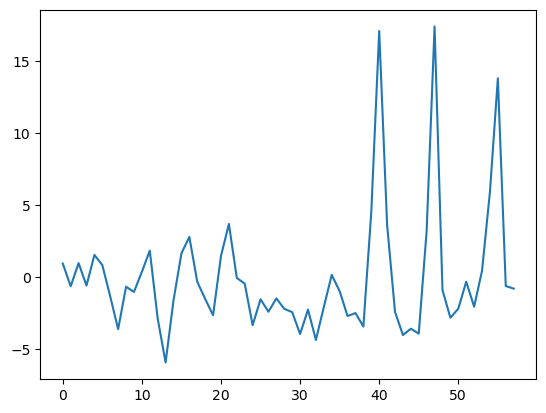

In [91]:
# plt.plot(df2.ECG)
plt.plot(X_transformed[:,0])
# plt.plot(X_transformed[:,1])
# plt.plot(X_transformed[:,2])
# plt.plot(X_transformed[:,3])
# plt.xlim(0, 100)

In [92]:
X_transformed

array([[ 9.44090040e-01, -4.28519945e-01,  6.25391626e+00,
         2.18422627e+00],
       [-6.28402359e-01,  7.03399584e-01, -1.12319144e+00,
        -2.16368224e-02],
       [ 9.74966321e-01, -2.19752436e+00, -3.60417281e+00,
        -1.05003338e+00],
       [-5.81289138e-01, -2.23252402e-01, -4.36906542e+00,
         2.94836711e-01],
       [ 1.54223372e+00, -2.46617530e+00,  5.66784876e+00,
        -9.68243615e-01],
       [ 8.36347764e-01, -8.60553292e-01,  1.07880729e+00,
         3.90778726e+00],
       [-1.33659215e+00,  4.59505522e-01, -1.00230864e+00,
         4.43212015e-04],
       [-3.60446107e+00,  3.93145017e-01,  3.11336384e+00,
        -1.16254837e+00],
       [-6.60144528e-01, -1.97515418e+00, -2.35246189e+00,
        -5.04803275e-01],
       [-1.01783898e+00, -4.87841761e-01,  2.20852546e+00,
         4.15639957e-01],
       [ 3.68068255e-01, -9.82659696e-01, -8.42640552e-01,
         3.95084743e-01],
       [ 1.83888055e+00, -1.03622770e+00, -1.54647014e+00,
      

In [93]:
record = wfdb.rdrecord(PATH + "a01r", sampfrom=SAMPFROM, sampto=SAMPTO)

df = record.to_dataframe()
df['time'] = df.index.microseconds / 1000 + df.index.seconds * 1000
df = df[['time', 'Resp C', 'Resp A', 'Resp N']]
df.reset_index(drop=True, inplace=True)
df.head()

,time,Resp C,Resp A,Resp N
0,0.0,-0.02540,0.30765,-0.07515
1,10.0,-0.02250,0.31220,-0.07800
2,20.0,-0.01960,0.31675,-0.08090
3,30.0,-0.01675,0.32130,-0.08380
4,40.0,-0.01385,0.32585,-0.08670


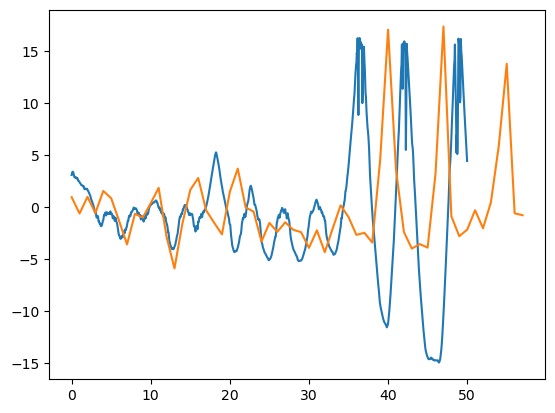

In [94]:
#plt.plot(df2['time'], df2['ECG'])
# plt.plot(df['time'], df['Resp C'])
plt.plot(df['time']/1000, df['Resp A']*10)
# plt.plot(df['time'], df['Resp N'])


plt.plot(X_transformed[:,0])

In [95]:
y_resp_norm = (df['Resp A']-min(df['Resp A'])) / max(df['Resp A']-min(df['Resp A']))
y_PCA_norm = (X_transformed[:,0]-min(X_transformed[:,0])) / max(X_transformed[:,0]-min(X_transformed[:,0]))
coeff = y_resp_norm.size/100 / y_PCA_norm.size

Text(0.5, 1.0, 'Zestawienie składowej oddechowej odseparowanej za pomocą PCA, jak i gotowej z bazy')

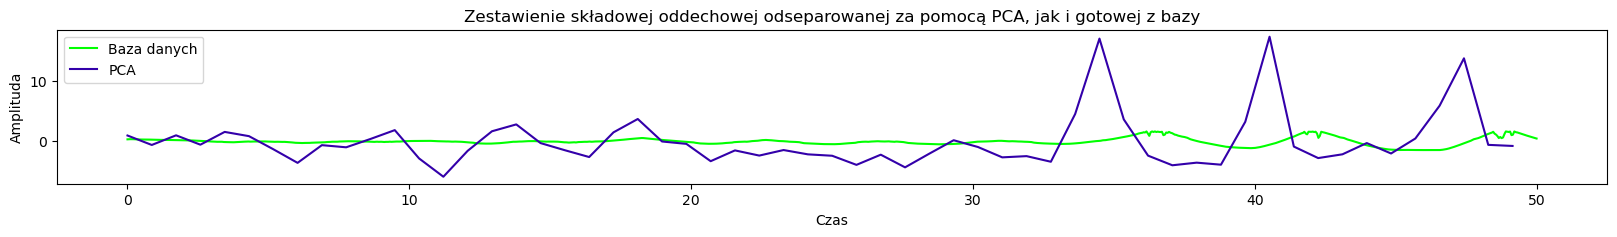

In [96]:
plt.figure(figsize=(20, 2))
plt.plot(df['time']/1000, df['Resp A'], label='Baza danych', color='lime')
plt.plot(np.arange(X_transformed[:,0].size)*coeff, X_transformed[:,0], label='PCA', color=('#3300AA'))
plt.legend()

plt.xlabel('Czas')
plt.ylabel('Amplituda')
plt.title('Zestawienie składowej oddechowej odseparowanej za pomocą PCA, jak i gotowej z bazy')

Text(0.5, 1.0, 'Zestawienie składowej oddechowej odseparowanej za pomocą PCA, jak i gotowej z bazy')

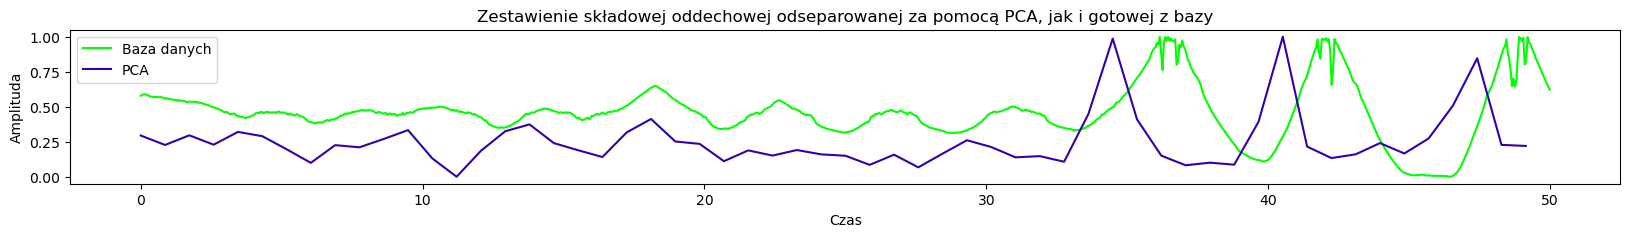

In [97]:
plt.figure(figsize=(20, 2))
plt.plot(df['time']/1000, y_resp_norm, label='Baza danych', color='lime')
plt.plot(np.arange(X_transformed[:,0].size)*coeff, y_PCA_norm, label='PCA', color=('#3300AA'))
plt.legend()

plt.xlabel('Czas')
plt.ylabel('Amplituda')
plt.title('Zestawienie składowej oddechowej odseparowanej za pomocą PCA, jak i gotowej z bazy')

In [98]:
kpca = decomposition.KernelPCA(n_components=4, kernel='cosine')
X_ktransformed = kpca.fit_transform(X_scaled)

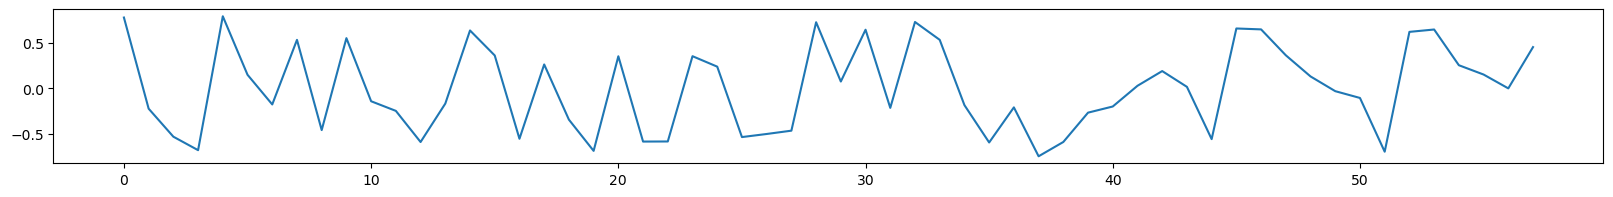

In [99]:
plt.figure(figsize=(20, 2))
plt.plot(X_ktransformed[:,0])

In [100]:
y_kPCA_norm = (X_ktransformed[:,0]-min(X_ktransformed[:,0])) / max(X_ktransformed[:,0]-min(X_ktransformed[:,0]))

Text(0.5, 1.0, "Zestawienie EDR z kPCA (kernel='cosine'), jak i gotowej z bazy")

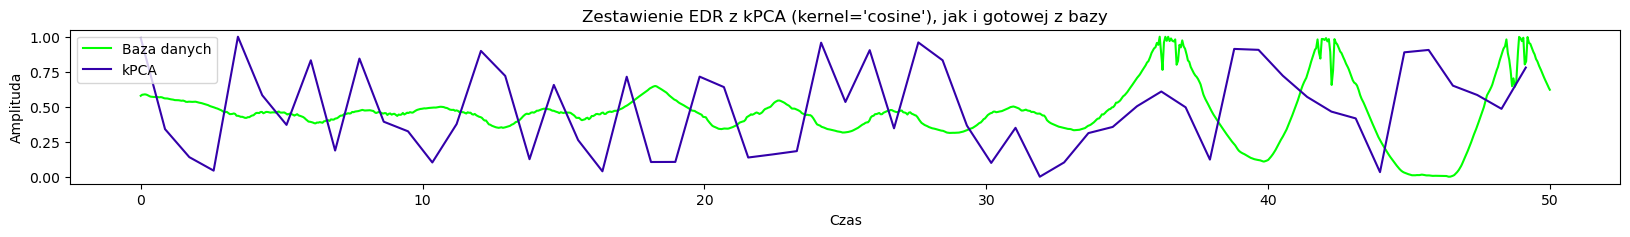

In [101]:
plt.figure(figsize=(20, 2))
plt.plot(df['time']/1000, y_resp_norm, label='Baza danych', color='lime')
plt.plot(np.arange(X_ktransformed[:,0].size)*coeff, y_kPCA_norm, label='kPCA', color=('#3300AA'))
plt.legend()

plt.xlabel('Czas')
plt.ylabel('Amplituda')
plt.title(f"Zestawienie EDR z kPCA (kernel=\'{kpca.kernel}\'), jak i gotowej z bazy")

In [102]:
ica = decomposition.FastICA(n_components=10)
X_ica_transformed = ica.fit_transform(X_scaled)

d:\ProgramData\Anaconda3\envs\labki\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


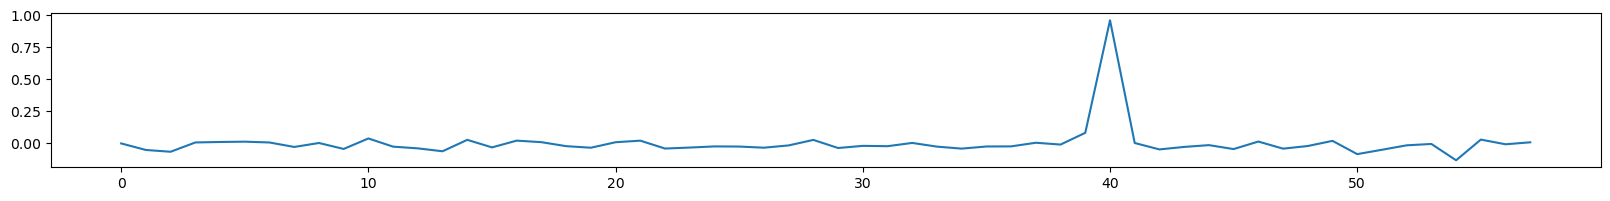

In [103]:
plt.figure(figsize=(20, 2))
plt.plot(X_ica_transformed[:,0])

In [104]:
y_ICA_norm = (X_ica_transformed[:,0]-min(X_ica_transformed[:,0])) / max(X_ica_transformed[:,0]-min(X_ica_transformed[:,0]))

Text(0.5, 1.0, 'Zestawienie EDR z ICA, jak i gotowej z bazy')

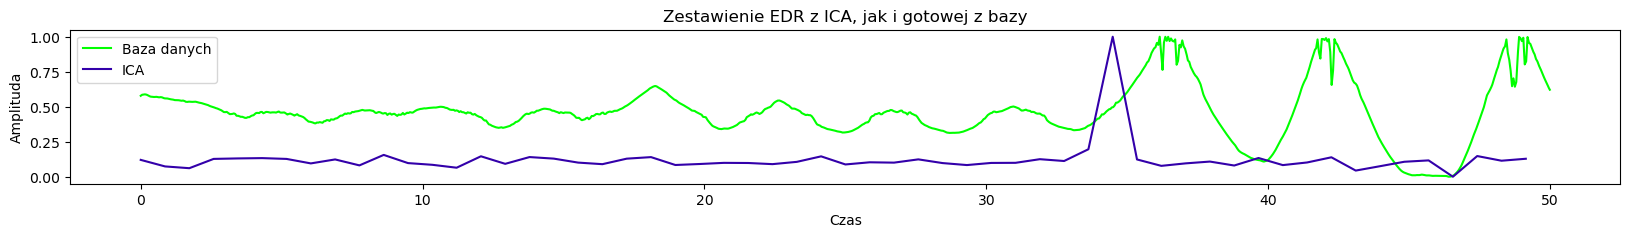

In [105]:
plt.figure(figsize=(20, 2))
plt.plot(df['time']/1000, y_resp_norm, label='Baza danych', color='lime')
plt.plot(np.arange(X_ktransformed[:,0].size)*coeff, y_ICA_norm, label='ICA', color=('#3300AA'))
plt.legend()

plt.xlabel('Czas')
plt.ylabel('Amplituda')
plt.title(f"Zestawienie EDR z ICA, jak i gotowej z bazy")